# Network inference of categorical variables: non-sequential data

In [1]:
import sys
import numpy as np
from scipy import linalg
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
%matplotlib inline

import inference

In [2]:
# setting parameter:
np.random.seed(1)

n = 20 # number of positions
m = 5 # number of values at each position
l = int(1*((n*m)**2)) # number of samples
g = 2.

sp = 0.5 # degree of sparsity
nm = n*m

In [3]:
w_true = inference.generate_interactions(n,m,g,sp)

In [4]:
h0_true = inference.generate_external_local_field(n,m,g)

In [5]:
s = inference.generate_sequences(w_true,h0_true,n,m,l)

('irepeat:', 0)
('irepeat:', 20)
('irepeat:', 40)
('irepeat:', 60)
('irepeat:', 80)


In [6]:
s.shape

(10000, 100)

In [23]:
np.savetxt('s.txt',s,fmt='%i')

In [13]:
def cov_inv(x,y):
    l,mx = x.shape
    my = y.shape[1]
    cab_inv = np.empty((my,my,mx,mx))
    
    for ia in range(my):
        #print(ia)
        for ib in range(my):
            if ib != ia:
                eps = y[:,ia] - y[:,ib]

                which_ab = eps !=0.                    
                xab = x[which_ab]          
                xab_av = np.mean(xab,axis=0)
                dxab = xab - xab_av
                cab = np.cov(dxab,rowvar=False,bias=True)

                cab_inv[ia,ib,:,:] = linalg.pinv(cab,rcond=1e-15)    
                
    return cab_inv

In [14]:
def fit(x,y,cab_inv,nloop=20):
    l,mx = x.shape
    my = y.shape[1]
        
    w = np.random.normal(0.0,1./np.sqrt(mx),size=(mx,my))
    h0 = np.random.normal(0.0,1./np.sqrt(mx),size=my)
    
    cost = np.full(nloop,100.) 
    for iloop in range(nloop):
        h = h0[np.newaxis,:] + x.dot(w)

        # stopping criterion --------------------
        p = np.exp(h)
        p /= p.sum(axis=1)[:,np.newaxis]

        cost[iloop] = ((y - p)**2).mean()
        if iloop > 1 and cost[iloop] >= cost[iloop-1]: break
        #-----------------------------------------    

        for ia in range(my):
            wa = np.zeros(mx)
            ha0 = 0.
            for ib in range(my):
                if ib != ia:
                    eps = y[:,ia] - y[:,ib]
                    which_ab = eps!=0.

                    eps_ab = eps[which_ab]
                    xab = x[which_ab]

                    # ----------------------------
                    xab_av = xab.mean(axis=0)
                    dxab = xab - xab_av

                    h_ab = h[which_ab,ia] - h[which_ab,ib]

                    which_non_zero = h_ab!=0
                    ha = eps_ab[which_non_zero]*h_ab[which_non_zero]/np.tanh(h_ab[which_non_zero]/2.)

                    dhdx = dxab*((ha - ha.mean())[:,np.newaxis])
                    dhdx_av = dhdx.mean(axis=0)

                    wab = cab_inv[ia,ib,:,:].dot(dhdx_av)   # wa - wb
                    h0ab = ha.mean() - xab_av.dot(wab)      # ha0 - hb0

                    wa += wab
                    ha0 += h0ab

            w[:,ia] = wa/my
            h0[ia] = ha0/my
    return w,h0            

In [15]:
mx = np.random.randint(5,6,size=n)

mx_cumsum = np.insert(mx.cumsum(),0,0)
i1i2 = np.stack([mx_cumsum[:-1],mx_cumsum[1:]]).T

In [16]:
my = np.random.randint(5,6,size=n)

In [17]:
mx_sum = mx.sum()
my_sum = my.sum()
print(mx_sum,my_sum)

(100, 100)


In [18]:
w_infer = np.zeros((mx_sum,my_sum))
h0_infer = np.zeros(my_sum)

for i in range(n):
    print(i)
    
    i1,i2 = i1i2[i,0],i1i2[i,1]

    x = np.hstack([s[:,:i1],s[:,i2:]])
    y = s[:,i1:i2]
    
    cab_inv = cov_inv(x,y)    
    w,h0 = fit(x,y,cab_inv,nloop=20)
    
    w_infer[:i1,i1:i2] = w[:i1,:]
    w_infer[i2:,i1:i2] = w[i1:,:]
    h0_infer[i1:i2] = h0    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


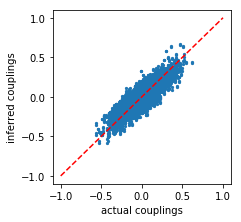

In [19]:
plt.figure(figsize=(3.2,3.2))

plt.plot([-1.,1.],[-1.,1.],'r--')
plt.scatter(w_true,w_infer,marker='o',s=5)
plt.xlabel('actual couplings')
plt.ylabel('inferred couplings')

plt.show()

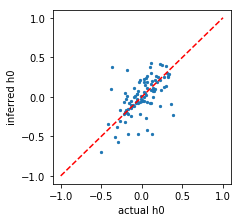

In [20]:
plt.figure(figsize=(3.2,3.2))

plt.plot([-1.,1.],[-1.,1.],'r--')
plt.scatter(h0_true,h0_infer,marker='o',s=5)
plt.xlabel('actual h0')
plt.ylabel('inferred h0')

plt.show()